# Representative Ordering: PCA + KMeans Visualization

This notebook projects MegaMedical image embeddings to 2D with PCA and colors points by KMeans cluster labels.

In [70]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
repo_root = Path("/data/ddmg/mvseg-ordering")
for path in [repo_root, repo_root / "UniverSeg", repo_root / "MultiverSeg"]:
    if str(path) not in sys.path:
        sys.path.append(str(path))
from experiments.dataset.mega_medical_dataset import MegaMedicalDataset
from experiments.encoders.multiverseg_encoder import MultiverSegEncoder
from experiments.encoders.clip import CLIPEncoder
from experiments.encoders.vit import ViTEncoder
from experiments.encoders.dinov2 import DinoV2Encoder
from experiments.encoders.medsam import MedSAMEncoder
from experiments.analysis.planb_utils import load_planb_summaries



## Load MegaMedical embeddings

Set a target index and encoder type; adjust `dataset_size` for speed.

In [71]:
# Choose a MegaMedical target index
dataset_split = "train"
dataset_size = None  # set None to use full dataset
encoder_type = "multiverseg"  # multiverseg | clip | vit | dinov2 | medsam
seed = 23
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if encoder_type == "multiverseg":
    encoder = MultiverSegEncoder(pooling="gap_gmp")
elif encoder_type == "clip":
    encoder = CLIPEncoder(model_name="ViT-B-32", pretrained="openai")
elif encoder_type == "vit":
    encoder = ViTEncoder(model_name="vit_b_16", pretrained=True)
elif encoder_type == "dinov2":
    encoder = DinoV2Encoder(model_name="facebook/dinov2-base")
elif encoder_type == "medsam":
    encoder = MedSAMEncoder(model_type="vit_b")
else:
    raise ValueError(f"Unknown encoder_type: {encoder_type}")
encoder = encoder.to(device).eval()

print(f"encoder_type={encoder_type}")


encoder_type=multiverseg


In [72]:
# --- Subset reconstruction from Plan B summary ---
# Load all subset summaries for a dataset family, then filter by task_id + subset_index.

procedure = "random_v_MSE_v2"  # e.g., random_v_MSE_v2, random_vs_uncertainty_v2, random_v_repr_v2
ablation = "pretrained_baseline"
dataset_family = "ACDC"
subset_index = 0

# task_id should match the full task id string (often family/folder_name).
task_id = "ACDC/ACDC_Challenge2017_MRI_2_label0_maxslice_idx624"

subset_df = load_planb_summaries(
    repo_root=repo_root,
    procedure=procedure,
    ablation=ablation,
    dataset=dataset_family,
    filename="subset_support_images_summary.csv",
)

if "task_id" in subset_df.columns:
    subset_rows = subset_df[(subset_df["task_id"] == task_id) & (subset_df["subset_index"] == subset_index)]
else:
    raise ValueError("Expected task_id column in combined subset summaries.")

# Try to recover dataset_target from the task_id (e.g., ..._idx624)
match = re.search(r"_idx(\d+)", task_id)
dataset_target = int(match.group(1))
ds = MegaMedicalDataset(
    dataset_target=dataset_target,
    split=dataset_split,
    dataset_size=dataset_size,
)

if subset_rows.empty:
    raise ValueError("No rows found for the specified task_id/subset_index.")

# The subset is defined by underlying dataset indices stored as image_id
if "image_id" not in subset_rows.columns:
    raise ValueError("Expected image_id column in subset CSV to reconstruct subset.")

subset_image_ids = sorted(set(int(x) for x in subset_rows["image_id"].tolist()))
print(f"Loaded subset {subset_index} with {len(subset_image_ids)} unique image_ids")
print("First few image_ids:", subset_image_ids[:10])





No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248
Loaded subset 0 with 10 unique image_ids
First few image_ids: [1, 9, 15, 17, 25, 32, 35, 39, 47, 57]


In [73]:
# --- Iterations used when the image was first (image_index == 0) ---
# Uses subset_support_images_summary.csv; averages over permutations if needed.
iterations_policy = "mse_min"  # or mse_min / uncertainty / etc
first_position = 0

iter_df = subset_rows
iter_df = iter_df[iter_df["policy_name"] == iterations_policy]
iter_df = iter_df[iter_df["image_index"] == first_position]

if iter_df.empty:
    print("No rows found for the selected policy/subset/image_index.")
    iter_map = {}
else:
    if "image_id" not in iter_df.columns:
        raise ValueError("Expected image_id column in subset CSV.")
    if "iterations_used" not in iter_df.columns:
        raise ValueError("Expected iterations_used column in subset CSV.")
    iter_map = (
        iter_df.groupby("image_id")["iterations_used"].mean().to_dict()
    )
    print(f"Loaded iterations_used for {len(iter_map)} image_ids (policy={iterations_policy}).")



Loaded iterations_used for 10 image_ids (policy=mse_min).


In [74]:
# --- Best start image by initial_dice at image_index == 0 (policy-specific) ---
# For uncertainty policies, this highlights which image would have been best to start with.
best_start_policy = iterations_policy  # default to the ordering policy used above

best_df = subset_rows
best_df = best_df[best_df["policy_name"] == best_start_policy]

best_start_image_id = None
best_start_initial_dice = None
keys = ["subset_index", "permutation_index"]
per_perm = (
    best_df.groupby(keys, as_index=False)["initial_dice"]
    .mean()
    .rename(columns={"initial_dice": "perm_score"})
)
start_map = (
    best_df[best_df["image_index"] == first_position]
    .groupby(keys, as_index=False)["image_id"]
    .first()
    .rename(columns={"image_id": "start_image_id"})
)

per_perm = per_perm.merge(start_map, on=keys, how="left")
if per_perm.empty:
    print("No permutations found to select best start.")
else:
    best_row = per_perm.loc[per_perm["perm_score"].idxmax()]
    best_start_image_id = best_row["start_image_id"]
    best_start_initial_dice = best_row["perm_score"]
    print(
        f"best_start_image_id={best_start_image_id} with initial_dice={best_start_initial_dice:.4f} "
        f"(policy={best_start_policy})"
    )



best_start_image_id=47.0 with initial_dice=0.5620 (policy=mse_min)


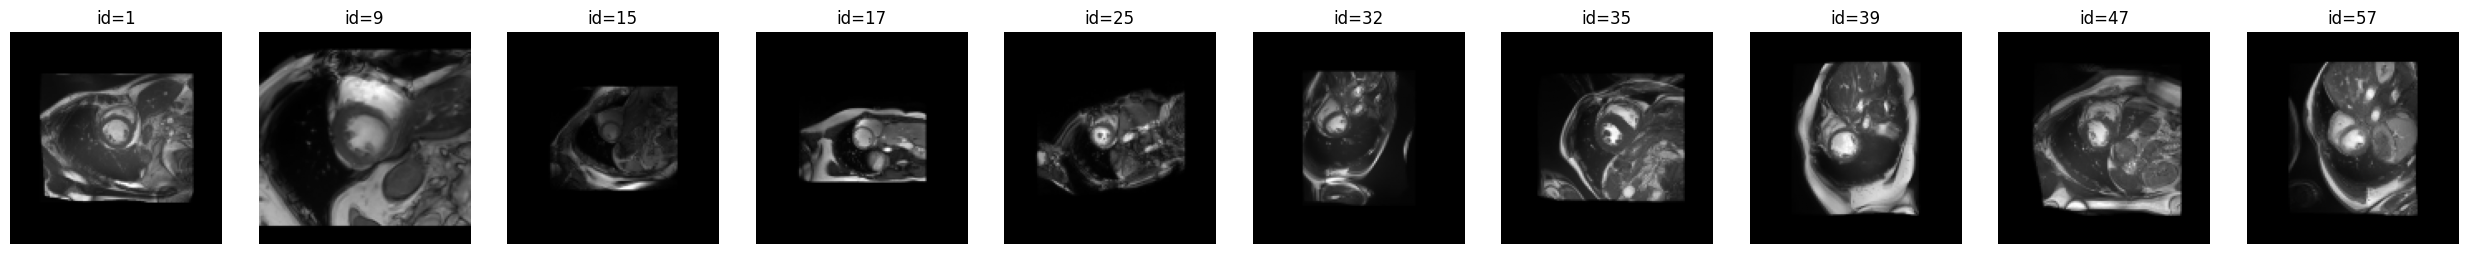

In [75]:
# Visualize the reconstructed subset images (first 10 by default)
max_show = 10
n_show = min(max_show, len(subset_image_ids))

fig, axes = plt.subplots(1, n_show, figsize=(2.5 * n_show, 2.5))
if n_show == 1:
    axes = [axes]

for ax, data_idx in zip(axes, subset_image_ids[:n_show]):
    item = ds.get_item_by_data_index(int(data_idx))
    img = item[0] if isinstance(item, (tuple, list)) else item
    # img: (C,H,W) tensor
    img_np = img.detach().cpu().numpy()
    if img_np.ndim == 3 and img_np.shape[0] == 1:
        img_np = img_np[0]
        ax.imshow(img_np, cmap="gray")
    elif img_np.ndim == 3:
        img_np = img_np.transpose(1, 2, 0)
        ax.imshow(img_np)
    else:
        ax.imshow(img_np, cmap="gray")
    ax.set_title(f"id={data_idx}")
    ax.axis("off")
plt.tight_layout()



In [76]:
# Compute embeddings Z and keep the original images for visualization
embeddings = []
images = []

with torch.no_grad():
    indices_to_use = subset_image_ids if "subset_image_ids" in globals() and subset_image_ids is not None else list(range(len(ds)))
    for i, idx in enumerate(indices_to_use):
        item = ds.get_item_by_data_index(int(idx))
        img = item[0] if isinstance(item, (tuple, list)) else item
        img = img.to(device)
        emb = encoder(img).detach().cpu().numpy()
        embeddings.append(emb.squeeze(0))
        images.append(img.detach().cpu().numpy())

Z = np.stack(embeddings, axis=0)
images = np.stack(images, axis=0)  # (N, C, H, W)
print("Z shape:", Z.shape)
print("images shape:", images.shape)



Z shape: (10, 512)
images shape: (10, 1, 128, 128)


## Visualize original images (subset)

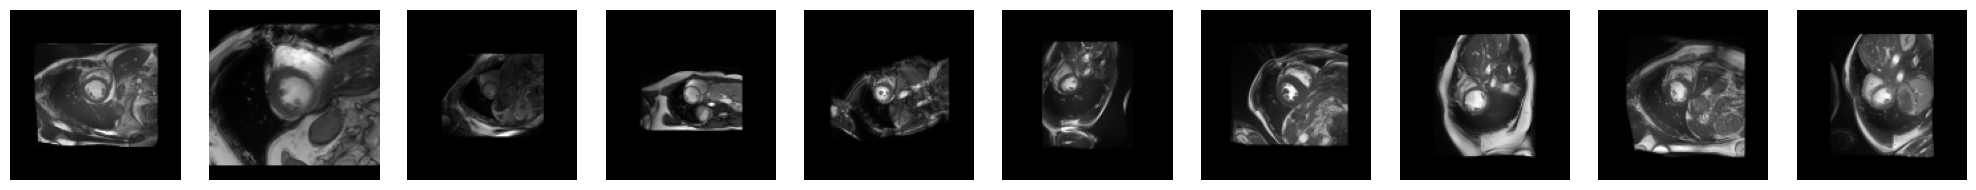

In [77]:
n_show = min(10, images.shape[0])
fig, axes = plt.subplots(1, n_show, figsize=(2 * n_show, 2))
if n_show == 1:
    axes = [axes]
for i in range(n_show):
    img = images[i]
    if img.ndim == 3:  # C, H, W -> H, W (if single-channel)
        if img.shape[0] == 1:
            img = img[0]
        else:
            img = np.transpose(img, (1, 2, 0))
    axes[i].imshow(img, cmap='gray' if img.ndim == 2 else None)
    axes[i].axis('off')
plt.tight_layout()
plt.show()


## PCA + KMeans + silhouette

silhouette_score: 0.1779
centroid_nearest_image_id=1
best_start_image_id=47.0
[0.09049036 0.17058672 0.13735473 0.10170949 0.10548652 0.1029576
 0.09236821 0.11815628 0.11620118 0.09230387]
[0 9 6 3 5 4 8 7 2 1]
[1, 9, 15, 17, 25, 32, 35, 39, 47, 57]
best_start_rank_by_centroid_distance=7 / 10
centroid_nearest_rank_by_initial_dice=3 / 10


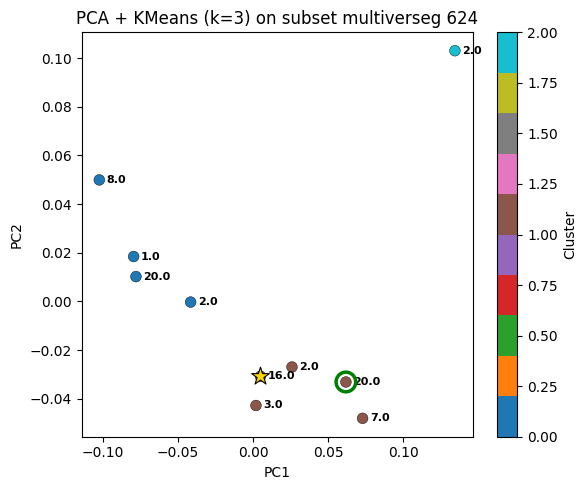

In [78]:
k = 3
Z_use = Z

pca = PCA(n_components=2, random_state=seed)
Z2 = pca.fit_transform(Z_use)

kmeans = KMeans(n_clusters=k, random_state=seed, n_init="auto")
labels = kmeans.fit_predict(Z_use)

# Mark closest-to-centroid point in the original embedding space
centroid = Z_use.mean(axis=0)
centroid_dists = np.linalg.norm(Z_use - centroid, axis=1)
centroid_idx = int(np.argmin(centroid_dists))

sil = np.nan
if len(np.unique(labels)) > 1 and Z_use.shape[0] > k:
    sil = silhouette_score(Z_use, labels)
print(f"silhouette_score: {sil:.4f}")

plt.figure(figsize=(6, 5))
sc = plt.scatter(
    Z2[:, 0],
    Z2[:, 1],
    c=labels,
    cmap="tab10",
    s=60,
    edgecolors="k",
    linewidths=0.3,
)
plt.scatter(Z2[centroid_idx, 0], Z2[centroid_idx, 1], marker="*", s=180, c="gold", edgecolors="k", linewidths=0.8, zorder=5, label="Centroid-nearest")

plot_image_ids = list(subset_image_ids)

centroid_image_id = plot_image_ids[centroid_idx]
print(f"centroid_nearest_image_id={centroid_image_id}")
print(f"best_start_image_id={best_start_image_id}")
best_idx = plot_image_ids.index(best_start_image_id)
# If best-start overlaps centroid-nearest, nudge to the right
dx = 0.01 if best_idx == centroid_idx else 0.0
dy = 0.0
plt.scatter(
    Z2[best_idx, 0] + dx,
    Z2[best_idx, 1] + dy,
    marker="o",
    s=200,
    facecolors="none",
    edgecolors="green",
    linewidths=2.5,
    zorder=7,
    label="Best start (init Dice)",
)

# Report rank positions for best-start and centroid-nearest

# Rank of best-start by increasing distance to centroid
dist_order = np.argsort(centroid_dists)
print(centroid_dists)
print(dist_order)
print(plot_image_ids)
best_idx = plot_image_ids.index(best_start_image_id)
best_rank = int(np.where(dist_order == best_idx)[0][0]) + 1
print(f"best_start_rank_by_centroid_distance={best_rank} / {len(plot_image_ids)}")

# Rank of centroid-nearest by initial_dice across permutations (start image == centroid)
centroid_image_id = plot_image_ids[centroid_idx]
per_perm_sorted = per_perm.sort_values("perm_score", ascending=False).reset_index(drop=True)
match_rows = per_perm_sorted[per_perm_sorted["start_image_id"] == centroid_image_id]
centroid_rank = int(match_rows.index[0]) + 1
print(f"centroid_nearest_rank_by_initial_dice={centroid_rank} / {len(per_perm_sorted)}")

plt.xlabel("PC1")
plt.ylabel("PC2")
title_scope = "subset"
plt.title(f"PCA + KMeans (k={k}) on {title_scope} {encoder_type} {dataset_target}")
plt.colorbar(sc, label="Cluster")
plt.tight_layout()

# Optional: annotate points with iterations_used when image was first in sequence
annotate_iters = True
for (x, y, img_id) in zip(Z2[:, 0], Z2[:, 1], plot_image_ids):
    if img_id in iter_map:
        plt.text(x + 0.005, y, f"{iter_map[img_id]:.1f}", fontsize=8, ha="left", va="center", fontweight="bold")
plt.show()






## Visualize images by cluster

This shows a grid of images for each cluster label.

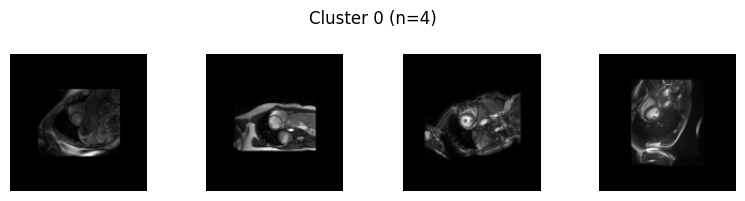

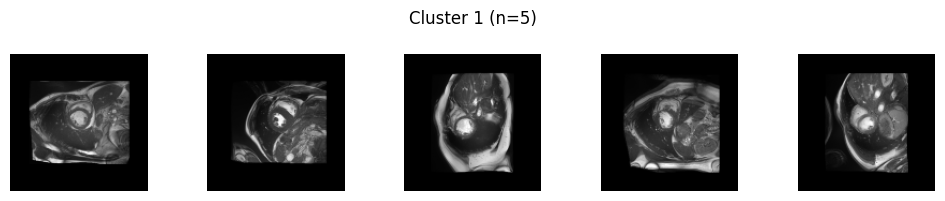

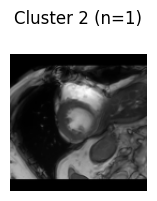

In [79]:
# Show images for each cluster
# Assumes images_subset (subset) or images (full) are aligned with Z_use.

images_use =  images

if images_use is None:
    raise ValueError('images not found; make sure images were loaded alongside Z.')

max_per_cluster = 10
for c in range(k):
    idxs = np.where(labels == c)[0]
    if idxs.size == 0:
        continue
    idxs = idxs[:max_per_cluster]
    n_show = idxs.size
    fig, axes = plt.subplots(1, n_show, figsize=(2 * n_show, 2))
    if n_show == 1:
        axes = [axes]
    for j, idx in enumerate(idxs):
        img = images_use[idx]
        if img.ndim == 3:  # C, H, W -> H, W (if single-channel)
            if img.shape[0] == 1:
                img = img[0]
            else:
                img = np.transpose(img, (1, 2, 0))
        axes[j].imshow(img, cmap='gray' if img.ndim == 2 else None)
        axes[j].axis('off')
    fig.suptitle(f'Cluster {c} (n={idxs.size})')
    plt.tight_layout()
    plt.show()
